![tower_bridge](tower_bridge.jpeg)

As the climate changes, predicting the weather becomes ever more important for businesses. Since the weather depends on a lot of different factors, you will want to run a lot of experiments to determine what the best approach is to predict the weather. In this project, you will run experiments for different regression models predicting the mean temperature, using a combination of `sklearn` and `MLflow`.

You will be working with data stored in `london_weather.csv`, which contains the following columns:
- **date** - recorded date of measurement - (**int**)
- **cloud_cover** - cloud cover measurement in oktas - (**float**)
- **sunshine** - sunshine measurement in hours (hrs) - (**float**)
- **global_radiation** - irradiance measurement in Watt per square meter (W/m2) - (**float**)
- **max_temp** - maximum temperature recorded in degrees Celsius (°C) - (**float**)
- **mean_temp** - mean temperature in degrees Celsius (°C) - (**float**)
- **min_temp** - minimum temperature recorded in degrees Celsius (°C) - (**float**)
- **precipitation** - precipitation measurement in millimeters (mm) - (**float**)
- **pressure** - pressure measurement in Pascals (Pa) - (**float**)
- **snow_depth** - snow depth measurement in centimeters (cm) - (**float**)

Dropped nans rows of: ['date', 'cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'mean_temp', 'min_temp', 'precipitation', 'pressure']


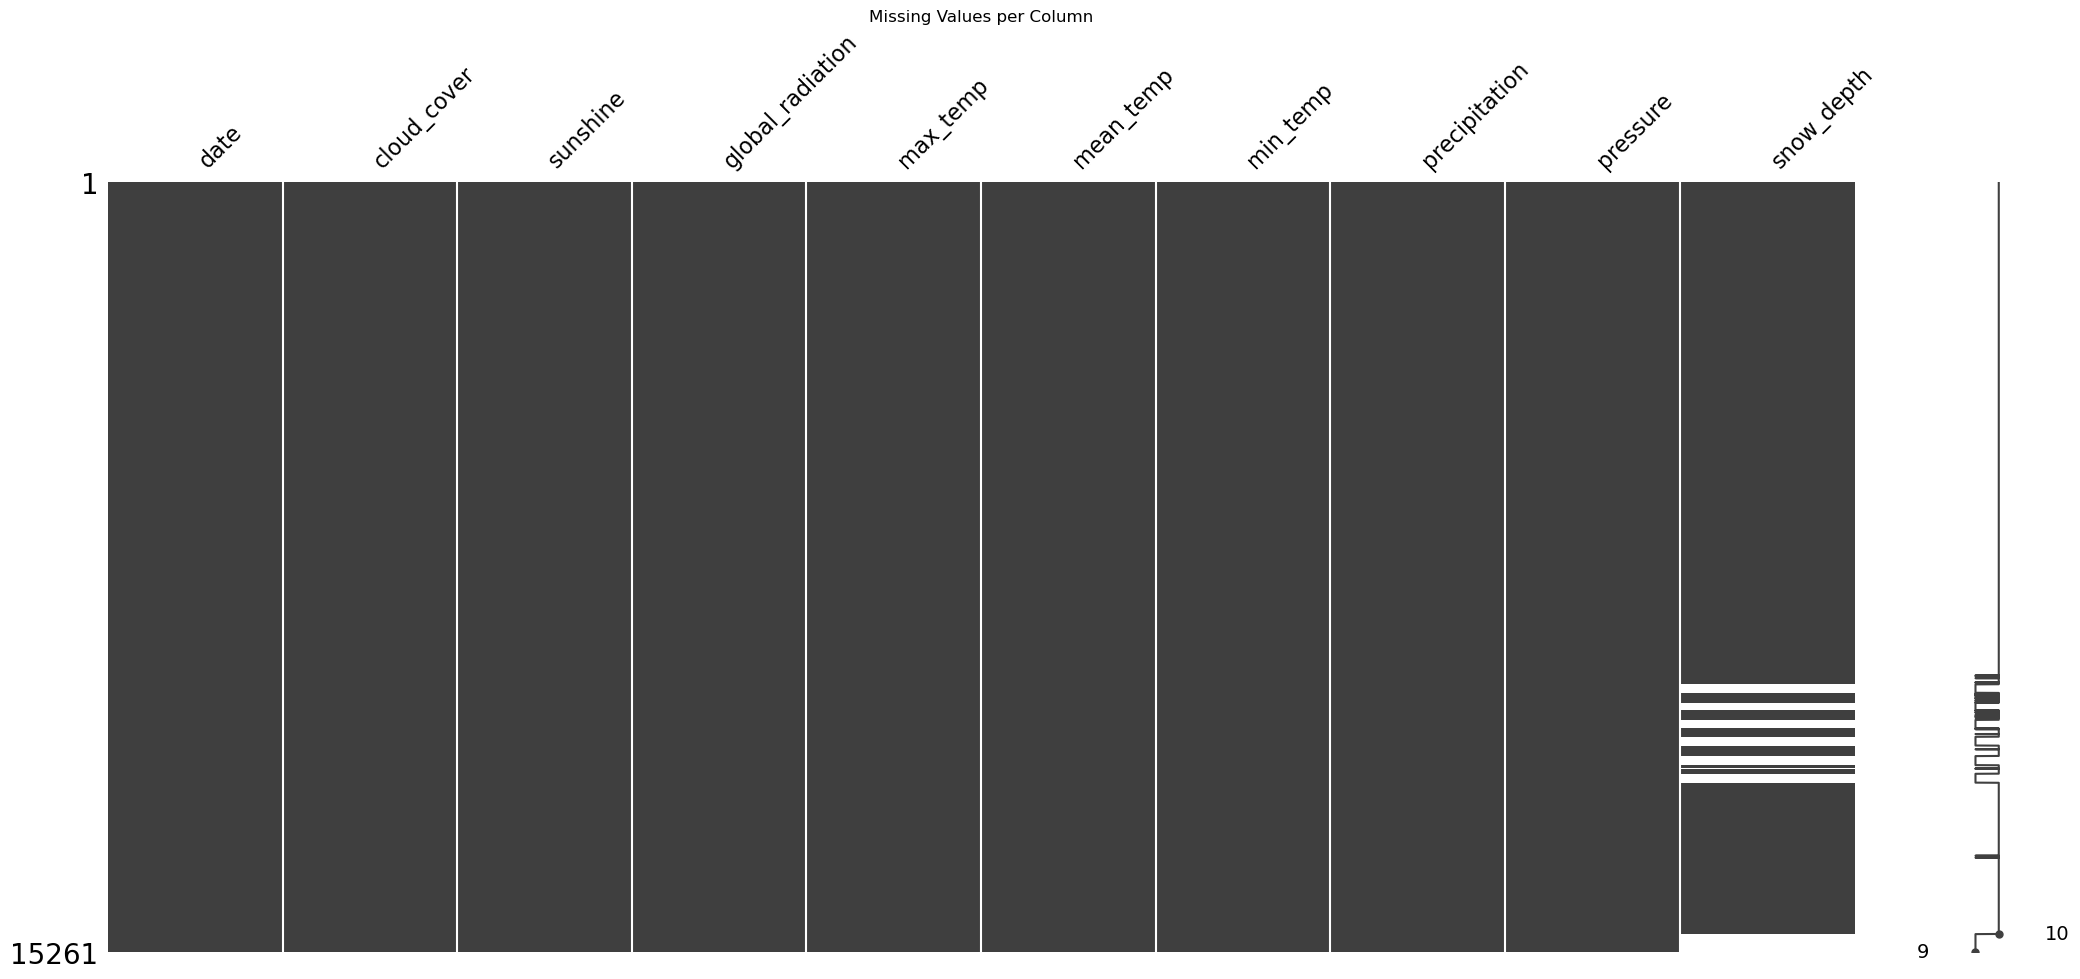

In [55]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import date
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Read in the data
weather = pd.read_csv("london_weather.csv")

assert weather.duplicated().any()==False

#If more than 5% nan in a columns --> replace, else drop rows
replace_cols=[]
drop_cols=[]
for col,num_nans in zip(weather.columns,weather.isna().sum().tolist()):
    #If num_nan per column is less than 5% of df length
    if num_nans >= len(weather)*0.05:
        replace_cols.append(col)
    else:
        drop_cols.append(col)

#drop values form each row where, total number of nans per col < 5% length of dataframe
print(f'Dropped nans rows of: {drop_cols}')
weather.dropna(subset=drop_cols, inplace=True)


msno.matrix(weather)
plt.title('Missing Values per Column')
plt.show()

In [56]:
#Filling with median due to the outliers seen
weather['snow_depth'].fillna(weather['snow_depth'].median(), inplace=True)

assert weather.isna().sum().sum() == 0


## CORRELATIONS

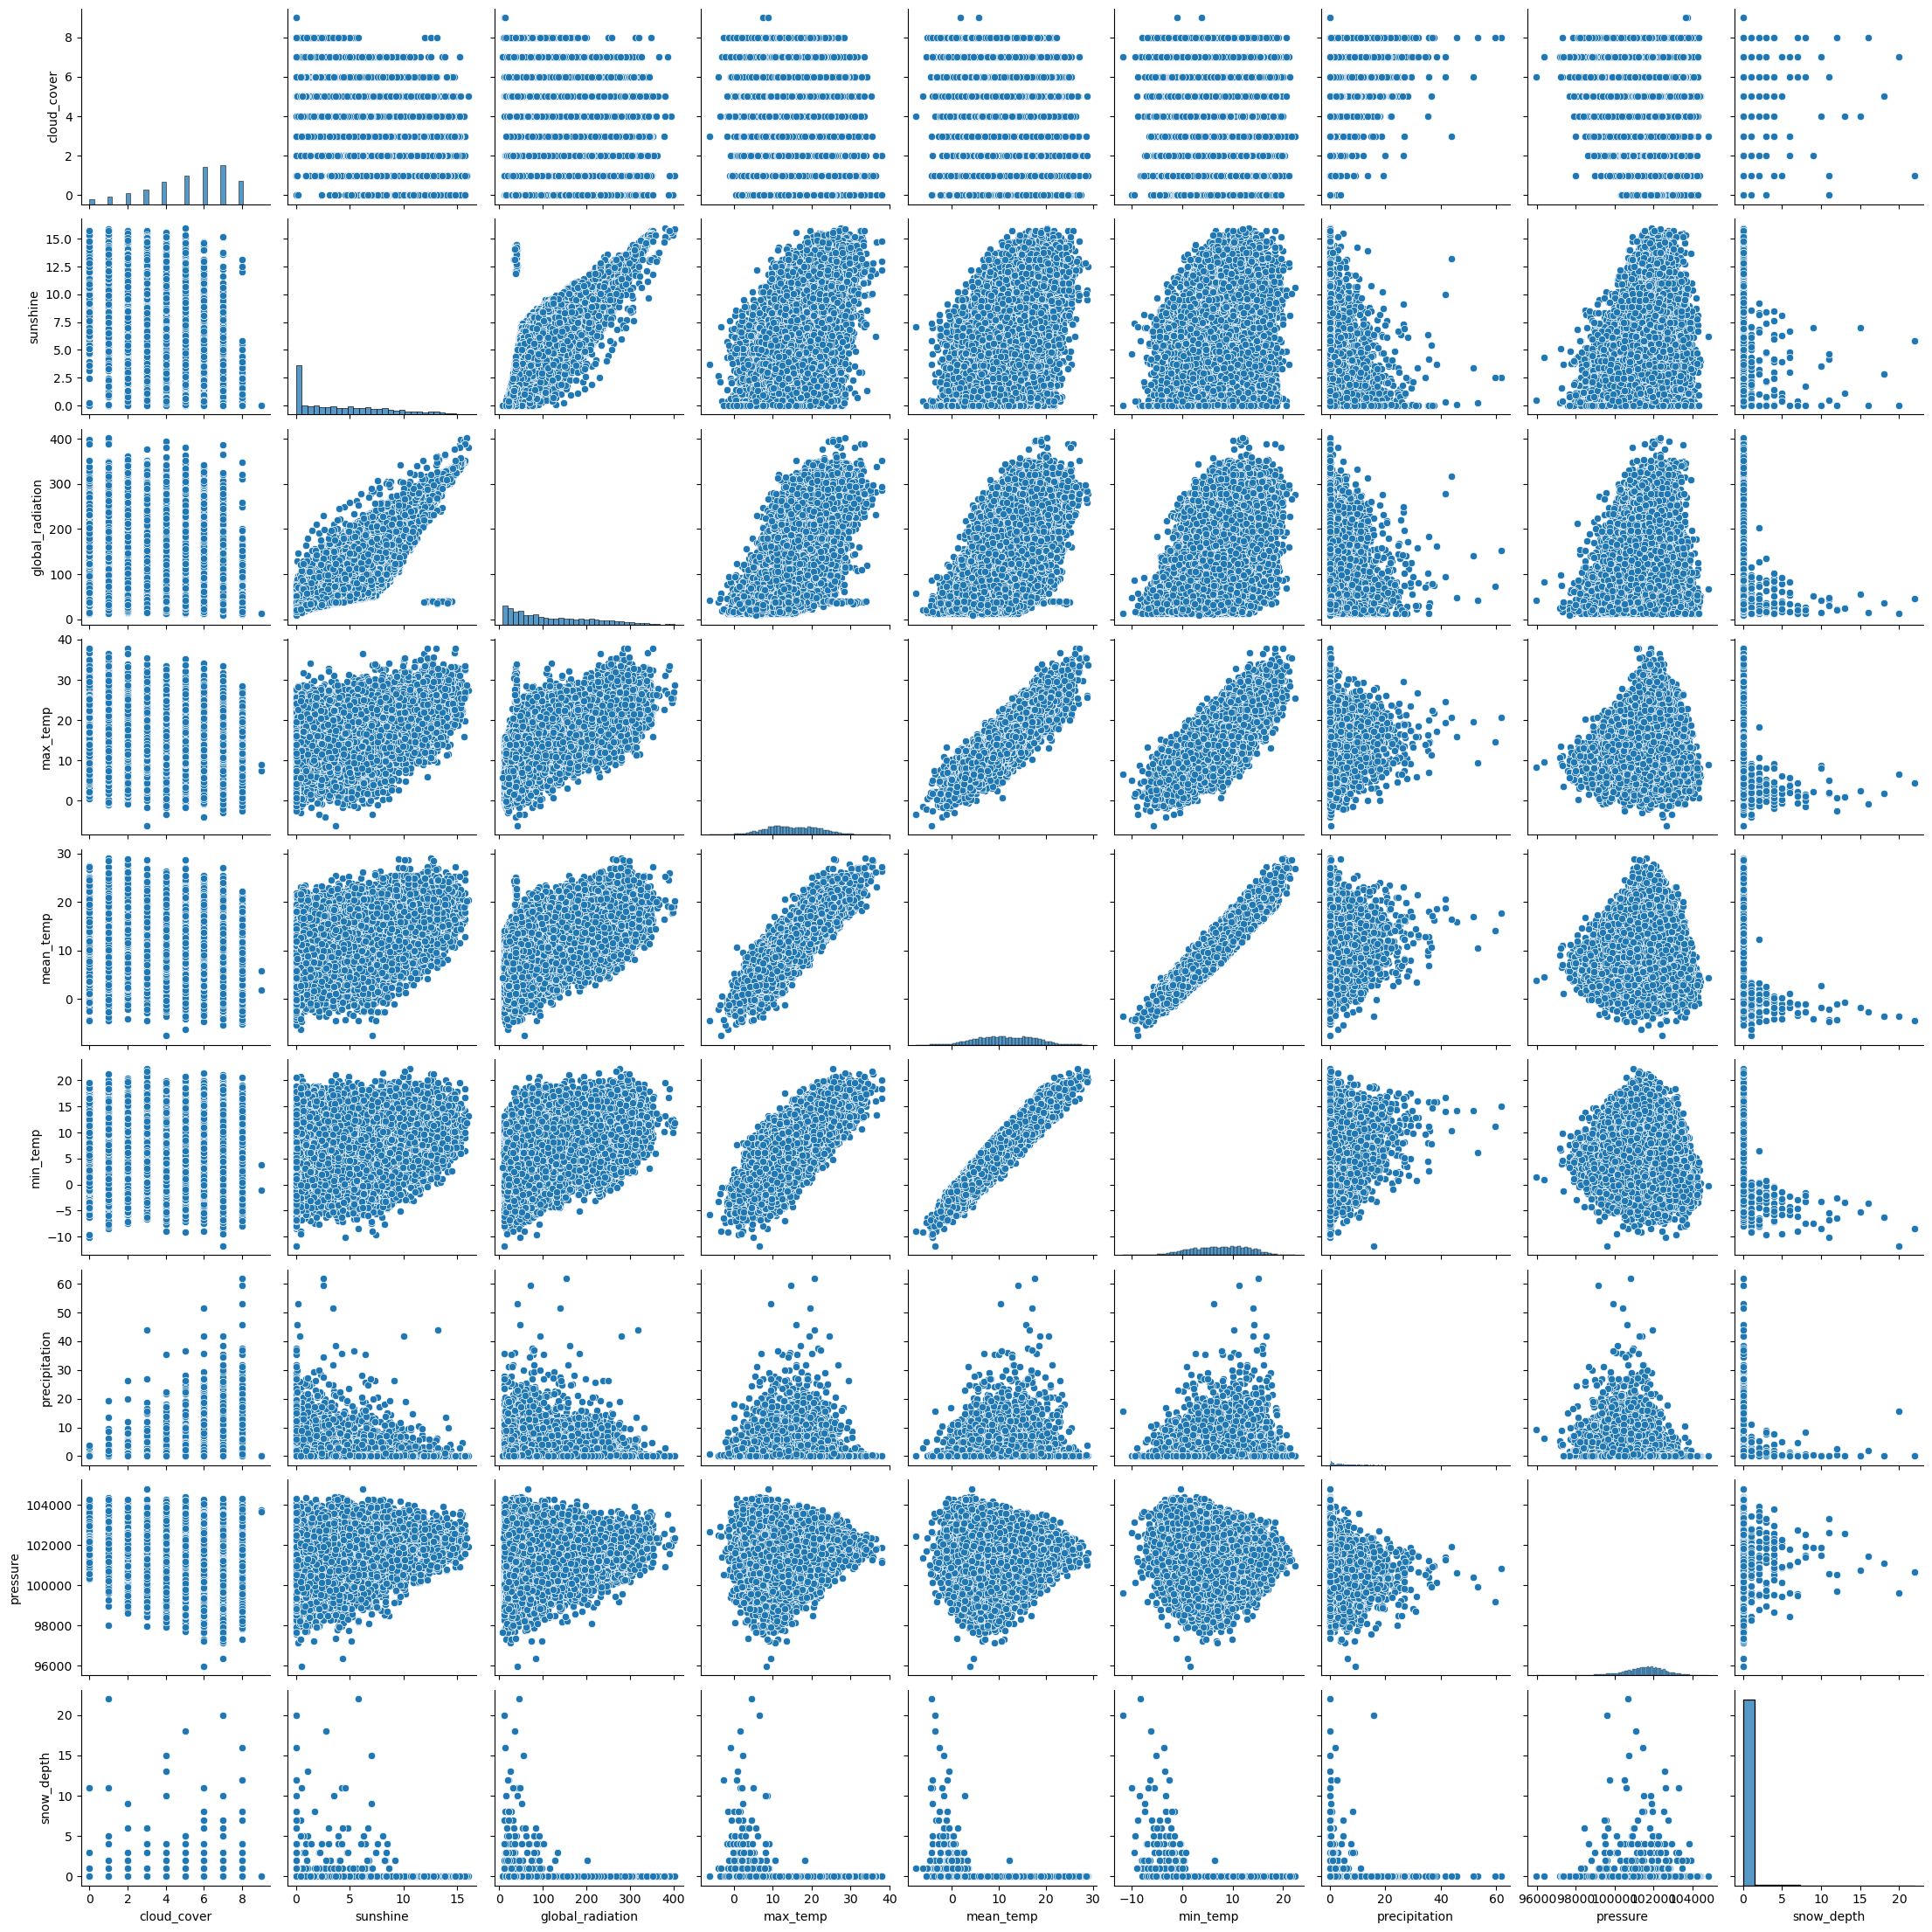

In [57]:
#Correaltions without date
sns.pairplot(data=weather.drop('date', axis=1))

## DATA PREPROCESSING

#### DATE

In [58]:
weather['date']=pd.to_datetime(weather['date'], format='%Y%m%d')
weather.sort_values(by='date', inplace=True)
display(weather.head())

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,1979-01-04,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,1979-01-05,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0



### Train Test Split (Date-Ordered)

In [59]:
#We don't want to split the data randomly, we're going to do a time-based split to see if the model predicts well most recent values in date.
target = 'mean_temp'
X = weather.drop(target, axis=1)
y = weather[target]

#EXTRACTING TIME FEATURES
X['year'] = X['date'].dt.year
X['month'] = X['date'].dt.month
X['day'] = X['date'].dt.day
X['day_of_week'] = X['date'].dt.dayofweek

#No random_state since we want a date-ordered split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train = X_train.drop(columns='date')
X_test = X_test.drop(columns='date')

## MLflow Project

0.8977685414838036


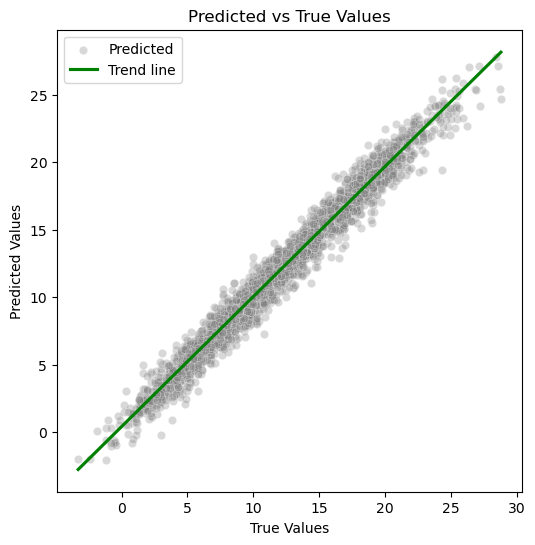

In [60]:
#mlflow.create_experiment('Temp_pred_model')
#mlflow.set_experiment('Temp_pred_model')
#mlflow.start_run()

rf_regress = RandomForestRegressor()
rf_regress.fit(X_train, y_train)

y_pred = rf_regress.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

y_results=pd.DataFrame()
y_results['true'] = y_test
y_results['pred'] = y_pred

plt.figure(figsize=(6, 6))

# Scatter for true vs pred (each a point)
sns.scatterplot(data=y_results, x='true', y='pred', color='gray', alpha=0.3, label='Predicted')

# Add regression line (trend)
sns.regplot(data=y_results, x='true', y='pred', scatter=False, color='green', label='Trend line')

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs True Values")
plt.legend()
plt.show()

params = rf_regress.get_params()

#mlflow.log_metric('rmse',rmse)
#mlflow.log_params(params)
#mlflow.log_artifact("london_weather.csv")

#mlflow.end_run()

## Param tuning

In [72]:
mlflow.end_run()
mlflow.start_run()

params_rf = {'n_estimators':[100,200,300,400,500],
            'max_depth': [4,6,8,10,12,15,20],
            'min_samples_leaf': [0.05,0.1,0.2,0.5,1],
            'max_features':['log2','sqrt',0.5,1,2,3,4,5]}
grid_rf = GridSearchCV(rf_regress, param_grid=params_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_rf.fit(X_train, y_train)
y_pred = grid_rf.predict(X_test)

rmse_grid = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse_grid)
best_hyperparams = grid_rf.best_params_
best_model = grid_rf.best_estimator_

mlflow.log_metric('rmse',rmse_grid)
mlflow.log_params(best_hyperparams)
mlflow.log_artifact("london_weather.csv")

mlflow.end_run()

0.8911324941142748


In [77]:
mlflow.search_runs()


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.rmse,params.max_depth,params.min_samples_leaf,params.max_features,...,params.n_jobs,params.bootstrap,params.min_weight_fraction_leaf,params.monotonic_cst,params.max_samples,params.random_state,tags.mlflow.source.type,tags.mlflow.source.name,tags.mlflow.runName,tags.mlflow.user
0,d49fbce2e7574aac9b12dda89270fadd,444573959879014688,FINISHED,file:///c:/Users/HP/Desktop/Dc/Unfinished%20Pr...,2025-10-03 11:25:55.476000+00:00,2025-10-03 11:53:18.964000+00:00,0.891132,12,1,0.5,...,None,None,None,None,None,None,LOCAL,c:\Users\HP\anaconda3\envs\jupyterfix\Lib\site...,intrigued-worm-278,HP
1,caa37b6ec27b4f01aa476a2e422eb6ca,444573959879014688,FINISHED,file:///c:/Users/HP/Desktop/Dc/Unfinished%20Pr...,2025-10-03 10:59:06.198000+00:00,2025-10-03 10:59:12.898000+00:00,0.899759,None,1,1.0,...,None,True,0.0,None,None,None,LOCAL,c:\Users\HP\anaconda3\envs\jupyterfix\Lib\site...,rumbling-cat-587,HP
